In [1]:
import numpy as np
from sklearn.decomposition import PCA
# 테스트할 데이터
X=np.array([[1,1,1,1,1,1,1,1,1,1,3,3,3,3,3,4,5,6],
             [1,2,1,1,1,1,1,1,1,1,3,4,3,3,3,4,5,6],
             [3,3,3,3,3,1,1,1,1,1,1,1,1,1,1,5,4,6],
             [3,4,3,3,3,1,2,1,1,1,1,1,1,1,1,5,4,5],
             [1,1,1,1,1,3,3,3,3,3,1,1,1,1,1,6,4,5],
             [1,2,1,1,1,3,3,3,2,3,1,1,1,1,1,5,4,5]])
# 주성분 분석(3개의 주성분으로 축소)
pca = PCA(n_components = 3)
X_pca = pca.fit_transform(X)
X_pca[:5]

array([[ 3.84432202,  0.20850925,  0.46823094],
       [ 4.09935419, -0.13332384, -0.49268129],
       [-1.70050345, -3.04924012,  0.76869479],
       [-2.21379239, -3.06986255, -0.66041977],
       [-2.102115  ,  3.36337224,  0.55345806]])

In [2]:
# 주성분1은 54%, 주성분2는 42%, 주성분3은 2%, 나머지가 2% (주성분 1,2만으로 96%를 설명함)
# 각 주성분의 축에 해당하는 데이터셋의 분산 비율
for i in pca.explained_variance_ratio_:
    print('{:.2f}'.format(i))

0.54
0.42
0.02


In [3]:
# 3개의 주성분으로 축소된 자료를 원래의 형태로 복원(정보의 손실이 있음)
X_inv = pca.inverse_transform(X_pca)
X_inv[0]
# 복원 단계에서 정보 손실이 발생할 수 있음

array([1.01080967, 1.1237144 , 1.01080967, 1.01080967, 1.01080967,
       1.04652366, 0.87642192, 1.04652366, 1.15635772, 1.04652366,
       2.94266667, 3.3355072 , 2.94266667, 2.94266667, 2.94266667,
       4.16176255, 4.97133333, 6.14683992])

In [4]:
# 재구성 오차(reconstruction error) 계산 : 원본 데이터와 압축 후 원복한 데이터 사이의 평균 제곱 거리
1 - pca.explained_variance_ratio_.sum()

0.01518968553184119

In [5]:
# MNIST 압축
# pip install tensorflow
# pip install keras
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# 28x28 => 784로 변환
X_train = X_train.reshape(60000, 784).astype('float32') / 255.0
X_test = X_test.reshape(10000, 784).astype('float32') / 255.0
print(y_train[:5])

[5 0 4 1 9]


In [6]:
# 적절한 차원의 수 선택
# 분산을 95%로 유지하는 차원의 수 계산
from sklearn.decomposition import PCA
import numpy as np
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d
#154

154

In [7]:
# 분산비율을 직접 지정하는 방식
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
print(pca.n_components_) # 차원(주성분의 수)
print(np.sum(pca.explained_variance_ratio_)) # 분산비율 합계

154
0.9501961


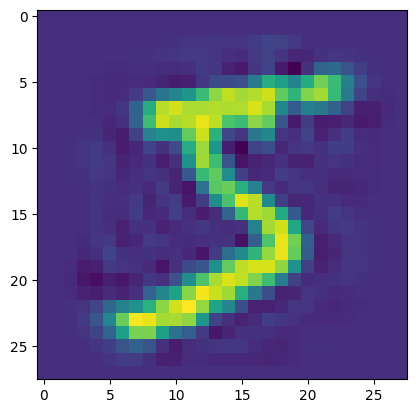

In [8]:
import matplotlib.pyplot as plt
# 154 차원으로 압축
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
# 784차원으로 복원
X_recovered = pca.inverse_transform(X_reduced)
plt.imshow(X_recovered.reshape(60000,28,28)[0])

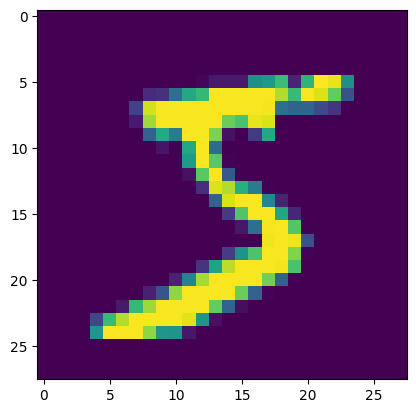

In [9]:
plt.imshow(X_train[0].reshape(28,28))

In [10]:
# 대량의 데이터의 경우 pca를 구현하기 위해 전체 데이터셋을 메모리에 올리는 것이 어려울 수 있음
# 점진적 pca(Incremental PCA) 알고리즘을 사용하여 미치배치 방법으로 pca를 실행할 수 있음
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
# 미니배치에 해당하는 부분만 사용하므로 메모리가 절약됨
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="")
    inc_pca.partial_fit(X_batch)
X_reduced = inc_pca.transform(X_train)
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

....................................................................................................

In [11]:
# 일반 PCA와 점진적 PCA로 MNIST 데이터를 변환한 결과 비교
# 평균이 같은지 확인
# allclose() 두 배열이 오차범위 내에서 같으면 True, 다르면 False
np.allclose(pca.mean_, inc_pca.mean_)
# True

False

In [12]:
np.mean(pca.mean_), np.mean(inc_pca.mean_)

(0.13066266, 0.1306604774024101)

In [13]:
# 랜덤 포레스트 모형
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=10, random_state=0)
rnd_clf.fit(X_train, y_train)
# 학습 시간: 6.5초

RandomForestClassifier(n_estimators=10, random_state=0)

In [14]:
# 정확도 출력
from sklearn.metrics import accuracy_score
y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)
# 94.92%

0.9469

In [15]:
# PCA를 사용하여 분산이 95%가 되도록 차원 축소
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

In [16]:
# 랜덤 포레스트 모형에 압축된 데이터 입력
rnd_clf2 = RandomForestClassifier(n_estimators=10, random_state=0)
rnd_clf2.fit(X_train_reduced, y_train)
# 학습 시간: 26.4초(느려짐)
# 차원 축소가 반드시 학습 시간 단축을 의미하지는 않음

RandomForestClassifier(n_estimators=10, random_state=0)

In [17]:
# 검증용 데이터셋으로 평가
X_test_reduced = pca.transform(X_test)
y_pred = rnd_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)
# 90.09%
# 차원 축소로 인한 정보 손실로 성능이 감소되는 것이 일반적

0.8942

In [18]:
# multinomial: 소프트맥스 방식의 로지스틱 회귀분석
#시간이 많이 걸림
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(multi_class="multinomial", max_iter=1000, random_state=0)
log_clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=0)

In [19]:
y_pred = log_clf.predict(X_test)
accuracy_score(y_test, y_pred)
# 92.22%

0.9256

In [20]:
# 주성분분석으로 축소된 데이터셋으로 학습
log_clf2 = LogisticRegression(multi_class="multinomial", max_iter=1000, random_state=0)
log_clf2.fit(X_train_reduced, y_train)
# 14.3초, 차원 축소 후 시간이 감소함

LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=0)

In [21]:
y_pred = log_clf2.predict(X_test_reduced)

accuracy_score(y_test, y_pred)

# 92.03% , 성능이 약간 감소되었으나 속도가 향상되었음

0.9233